In [1]:
from src.api.flipside_crypto import FlipsideCrypto
from src.misc.data import format_dtypes
import src.measures as measures

import pandas as pd
from matplotlib import pyplot as plt
%matplotlib widget


In [3]:
ts = 1672834013
pair = "USDC-ETH"

In [5]:
flipside = FlipsideCrypto("249f0e62-a575-4ddb-8ccd-b7618eb9d766")
syncs_and_swaps = flipside.get_syncs_and_swaps("uniswap-v2", pair, ts, amount=2000)

In [4]:
df = pd.DataFrame(syncs_and_swaps)
df.head()

,_log_id,block_number,block_timestamp,tx_hash,event_index,event_name,event_inputs
0,0x0c9a6a6610aa20a0d1a8dae3a1e15e6db698acd8444b...,16333918,2023-01-04 14:07:23.000,0x0c9a6a6610aa20a0d1a8dae3a1e15e6db698acd8444b...,194,Sync,"{'reserve0': '42434741500318', 'reserve1': '33..."
1,0x0c9a6a6610aa20a0d1a8dae3a1e15e6db698acd8444b...,16333918,2023-01-04 14:07:23.000,0x0c9a6a6610aa20a0d1a8dae3a1e15e6db698acd8444b...,195,Swap,"{'amount0In': '0', 'amount0Out': '306550903', ..."
2,0xcb934997b3ed72e57a11a2021cd99a0e2a7107fbf590...,16333921,2023-01-04 14:07:59.000,0xcb934997b3ed72e57a11a2021cd99a0e2a7107fbf590...,2,Sync,"{'reserve0': '42435324855117', 'reserve1': '33..."
3,0xcb934997b3ed72e57a11a2021cd99a0e2a7107fbf590...,16333921,2023-01-04 14:07:59.000,0xcb934997b3ed72e57a11a2021cd99a0e2a7107fbf590...,3,Swap,"{'amount0In': '583354799', 'amount0Out': '0', ..."
4,0x938359af1763c6791a0ad94c0e8541bf9e9528b69bb0...,16333928,2023-01-04 14:09:23.000,0x938359af1763c6791a0ad94c0e8541bf9e9528b69bb0...,16,Sync,"{'reserve0': '42434935939516', 'reserve1': '33..."


In [5]:
syncs_df = df[df["event_name"] == "Sync"]
swaps_df = df[df["event_name"] == "Swap"]

## Reserves after the Swap
For each swaps want to merge the previous sync (same tx_hash, event_index - 1)

#### __ATTENTION__: even though Sync is emitted before Swap, it uses the __reserve after__ values! 
If we want to know the reserve before, we need to merge with the next Sync



In [6]:
swaps_df["sync_event_index"] = 0
swaps_df["sync_event_index"] = swaps_df["event_index"] - 1


/var/folders/xv/9qwc_ryj6l98nrg9pnn_zp7h0000gn/T/ipykernel_9757/2335468949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swaps_df["sync_event_index"] = 0
/var/folders/xv/9qwc_ryj6l98nrg9pnn_zp7h0000gn/T/ipykernel_9757/2335468949.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swaps_df["sync_event_index"] = swaps_df["event_index"] - 1


In [7]:
df = pd.merge(swaps_df, syncs_df[["tx_hash", "event_index", "event_inputs"]], left_on=["tx_hash", "sync_event_index"], right_on=["tx_hash", "event_index"], how="left")
df = format_dtypes(df, {"event_inputs_x": dict, "event_inputs_y": dict})
dtypes =  {
    "amount0In": int, 
    "amount0Out": int, 
    "amount1In": int, 
    "amount1Out": int,
    "reserve0": int, 
    "reserve1": int}
df = format_dtypes(df, dtypes)
df.rename(columns={"reserve0": "reserve0_after", "reserve1": "reserve1_after"}, inplace=True)
df.head()

,_log_id,block_number,block_timestamp,tx_hash,event_index_x,event_name,event_inputs_x,sync_event_index,event_index_y,event_inputs_y,amount0In,amount0Out,amount1In,amount1Out,sender,to,reserve0_after,reserve1_after
0,0x0c9a6a6610aa20a0d1a8dae3a1e15e6db698acd8444b...,16333918,2023-01-04 14:07:23.000,0x0c9a6a6610aa20a0d1a8dae3a1e15e6db698acd8444b...,195,Swap,"{'amount0In': '0', 'amount0Out': '306550903', ...",194,194,"{'reserve0': '42434741500318', 'reserve1': '33...",0,306550903,245109969116886778,0,0x1111111254eeb25477b68fb85ed929f73a960582,0x74de5d4fcbf63e00296fd95d33236b9794016631,42434741500318,33828149486051957946193
1,0xcb934997b3ed72e57a11a2021cd99a0e2a7107fbf590...,16333921,2023-01-04 14:07:59.000,0xcb934997b3ed72e57a11a2021cd99a0e2a7107fbf590...,3,Swap,"{'amount0In': '583354799', 'amount0Out': '0', ...",2,2,"{'reserve0': '42435324855117', 'reserve1': '33...",583354799,0,0,463637612549270337,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xf29450019834d7874b4e306275c4334326ac27f1,42435324855117,33827685848439408675856
2,0x938359af1763c6791a0ad94c0e8541bf9e9528b69bb0...,16333928,2023-01-04 14:09:23.000,0x938359af1763c6791a0ad94c0e8541bf9e9528b69bb0...,17,Swap,"{'amount0In': '0', 'amount0Out': '388915601', ...",16,16,"{'reserve0': '42434935939516', 'reserve1': '33...",0,388915601,310963163089744374,0,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0xa72a482e7c667e7db32a2b7171e9e3e97f2c65c5,42434935939516,33827996811602498420230
3,0x783d49ea9d48039c6254497a1a889d1a3a565397db19...,16333936,2023-01-04 14:10:59.000,0x783d49ea9d48039c6254497a1a889d1a3a565397db19...,129,Swap,"{'amount0In': '1039282967', 'amount0Out': '0',...",128,128,"{'reserve0': '42435975222483', 'reserve1': '33...",1039282967,0,0,825982970246676825,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xbe1737dae50f225b9480d68ee8f889e81d364615,42435975222483,33827170828632251743405
4,0xd3fe02abaf9dd15a79291b2f13f4b202f17301b2108e...,16333936,2023-01-04 14:10:59.000,0xd3fe02abaf9dd15a79291b2f13f4b202f17301b2108e...,517,Swap,"{'amount0In': '0', 'amount0Out': '54484329', '...",516,516,"{'reserve0': '42435920738154', 'reserve1': '33...",0,54484329,43562069394324489,0,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x9d6f8ec99dc5c38b4d9915419f92a4808c6d89d1,42435920738154,33827214390701646067894


## Reserves before the Swap

1. Merge with offset index and use reserve_after. 
    - This will give wrong value if we had Mint/Burn/Transfer in between! But looking on flipside we only have Mint/Burn/Transfer very rarely (~10 vs 8500 swaps)
    
2. Calculate reserve_before from reserve_after and the in/out amounts. 
    - The amountIn/Out are already adjusted for fees. 
    - The Sync and Swap Event is emitted in `v2-core/contracts/UniswapV2Pair.swap`
    - this function is called from `v2-periphery/contracts/UniswapV2Router02._swap`, 
    - which is called from the `swapExactTokensForTokens` functions, where `getAmountsIn/Out` takes care of the fees.
    
Conclusion: 
- `reserve0_before = reserve0_after - amount0In + amount0Out`
- `reserve1_before = reserve1_after - amount1In + amount1Out`

In [8]:
df_reserves = df[["reserve0_after", "reserve1_after"]]
df_reserves.set_index(df_reserves.index + 1, inplace=True)
df_reserves.rename(columns={
    "reserve0_after": "reserve0_before", 
    "reserve1_after": "reserve1_before"
    }, inplace=True)

/var/folders/xv/9qwc_ryj6l98nrg9pnn_zp7h0000gn/T/ipykernel_9757/1318685682.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reserves.rename(columns={


In [9]:
df_all = pd.merge(df, df_reserves, left_index=True, right_index=True)
dfs = df_all[[
        "block_timestamp", 
        "amount0In", "amount0Out", "reserve0_before", "reserve0_after", 
        "amount1In", "amount1Out", "reserve1_before", "reserve1_after"
        ]]
dfs.head()

,block_timestamp,amount0In,amount0Out,reserve0_before,reserve0_after,amount1In,amount1Out,reserve1_before,reserve1_after
1,2023-01-04 14:07:59.000,583354799,0,42434741500318,42435324855117,0,463637612549270337,33828149486051957946193,33827685848439408675856
2,2023-01-04 14:09:23.000,0,388915601,42435324855117,42434935939516,310963163089744374,0,33827685848439408675856,33827996811602498420230
3,2023-01-04 14:10:59.000,1039282967,0,42434935939516,42435975222483,0,825982970246676825,33827996811602498420230,33827170828632251743405
4,2023-01-04 14:10:59.000,0,54484329,42435975222483,42435920738154,43562069394324489,0,33827170828632251743405,33827214390701646067894
5,2023-01-04 14:10:59.000,0,312679465,42435920738154,42435608058689,250000000000000000,0,33827214390701646067894,33827464390701646067894


### Token0 calculations

In [10]:
# calculate reserve0 before from reserve_after and amount0In/Out

dfs["reserve0_before_calc"] = dfs.apply(lambda row:  row["reserve0_after"] - row["amount0In"] + row["amount0Out"], axis=1)
mask = dfs["reserve0_before_calc"] == dfs["reserve0_before"]

print(f"Of {len(dfs)} swaps, the calculated `reserve0_before` coincides {mask.sum()} times. " \
    f"When the values are different ({len(dfs) - mask.sum()} times), it means that there was a "\
    f"Mint/Burn/Transfer between the Swaps and the merge 'Use Sync of Swap as reserve_before for next Swap' is not correct")

Of 995 swaps, the calculated `reserve0_before` coincides 994 times. When the values are different (1 times), it means that there was a Mint/Burn/Transfer between the Swaps and the merge 'Use Sync of Swap as reserve_before for next Swap' is not correct


/var/folders/xv/9qwc_ryj6l98nrg9pnn_zp7h0000gn/T/ipykernel_9757/2032137340.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs["reserve0_before_calc"] = dfs.apply(lambda row:  row["reserve0_after"] - row["amount0In"] + row["amount0Out"], axis=1)


### Token1 calculations


In [11]:
# calculate reserve1 before from reserve_after and amount0In/Out

dfs["reserve1_before_calc"] = dfs.apply(lambda row:  row["reserve1_after"] - row["amount1In"] + row["amount1Out"], axis=1)
mask = dfs["reserve1_before_calc"] == dfs["reserve1_before"]

print(f"Of {len(dfs)} swaps, the calculated `reserve1_before` coincides {mask.sum()} times. " \
    f"When the values are different ({len(dfs) - mask.sum()} times), it means that there was a "\
    f"Mint/Burn/Transfer between the Swaps and the merge 'Use Sync of Swap as reserve_before for next Swap' is not correct")

Of 995 swaps, the calculated `reserve1_before` coincides 994 times. When the values are different (1 times), it means that there was a Mint/Burn/Transfer between the Swaps and the merge 'Use Sync of Swap as reserve_before for next Swap' is not correct


/var/folders/xv/9qwc_ryj6l98nrg9pnn_zp7h0000gn/T/ipykernel_9757/674808551.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs["reserve1_before_calc"] = dfs.apply(lambda row:  row["reserve1_after"] - row["amount1In"] + row["amount1Out"], axis=1)


## Before and after Prices & Slippage

Imported from `src.measures`:

```python 
def calc_price_from_reserves(reserve0, token0_decimals, reserve1, token1_decimals):
    return (reserve0 / token0_decimals) / (reserve1 / token1_decimals)
    
def calc_slippage(price_before, price_after):
    return abs((price_before - price_after) / price_before)

```

In [12]:
## price before & after

token0_decimals = 10**6  # USDC
token1_decimals = 10**18  # ETH

dfs["price_before"] = dfs.apply(lambda row: measures.calc_price_from_reserves(
    row["reserve0_before_calc"], token0_decimals, row["reserve1_before_calc"], token1_decimals
    ), axis=1)
dfs["price_after"] = dfs.apply(lambda row: measures.calc_price_from_reserves(
    row["reserve0_after"], token0_decimals, row["reserve1_after"], token1_decimals
    ), axis=1)

/var/folders/xv/9qwc_ryj6l98nrg9pnn_zp7h0000gn/T/ipykernel_9757/2946832018.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs["price_before"] = dfs.apply(lambda row: measures.calc_price_from_reserves(
/var/folders/xv/9qwc_ryj6l98nrg9pnn_zp7h0000gn/T/ipykernel_9757/2946832018.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs["price_after"] = dfs.apply(lambda row: measures.calc_price_from_reserves(


In [13]:
dfs["slippage"] = dfs.apply(lambda row: measures.calc_slippage(row["price_before"], row["price_after"]), axis=1)
dfs.head()

/var/folders/xv/9qwc_ryj6l98nrg9pnn_zp7h0000gn/T/ipykernel_9757/1902106346.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs["slippage"] = dfs.apply(lambda row: measures.calc_slippage(row["price_before"], row["price_after"]), axis=1)


,block_timestamp,amount0In,amount0Out,reserve0_before,reserve0_after,amount1In,amount1Out,reserve1_before,reserve1_after,reserve0_before_calc,reserve1_before_calc,price_before,price_after,slippage
1,2023-01-04 14:07:59.000,583354799,0,42434741500318,42435324855117,0,463637612549270337,33828149486051957946193,33827685848439408675856,42434741500318,33828149486051957946193,1254.421012,1254.455449,0.000027
2,2023-01-04 14:09:23.000,0,388915601,42435324855117,42434935939516,310963163089744374,0,33827685848439408675856,33827996811602498420230,42435324855117,33827685848439408675856,1254.455449,1254.432421,0.000018
3,2023-01-04 14:10:59.000,1039282967,0,42434935939516,42435975222483,0,825982970246676825,33827996811602498420230,33827170828632251743405,42434935939516,33827996811602498420230,1254.432421,1254.493775,0.000049
4,2023-01-04 14:10:59.000,0,54484329,42435975222483,42435920738154,43562069394324489,0,33827170828632251743405,33827214390701646067894,42435975222483,33827170828632251743405,1254.493775,1254.490549,0.000003
5,2023-01-04 14:10:59.000,0,312679465,42435920738154,42435608058689,250000000000000000,0,33827214390701646067894,33827464390701646067894,42435920738154,33827214390701646067894,1254.490549,1254.472034,0.000015


## Trade Size and Price

In [14]:
dfs["tradesize_usdc"] = (dfs["amount0In"] + dfs["amount0Out"]) / 10**6
dfs["tradesize_eth"] = (dfs["amount1In"] + dfs["amount1Out"]) / 10**18

/var/folders/xv/9qwc_ryj6l98nrg9pnn_zp7h0000gn/T/ipykernel_9757/3688854099.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs["tradesize_usdc"] = (dfs["amount0In"] + dfs["amount0Out"]) / 10**6
/var/folders/xv/9qwc_ryj6l98nrg9pnn_zp7h0000gn/T/ipykernel_9757/3688854099.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs["tradesize_eth"] = (dfs["amount1In"] + dfs["amount1Out"]) / 10**18


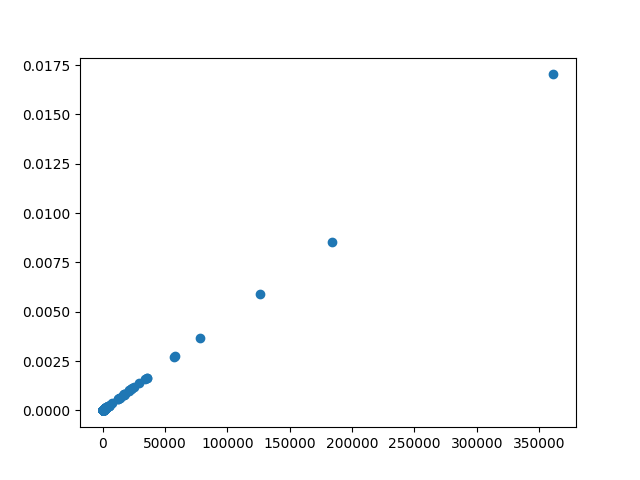

In [15]:
fig, axs = plt.subplots(1,1)
axs.scatter(dfs["tradesize_usdc"], dfs["slippage"])
plt.show()

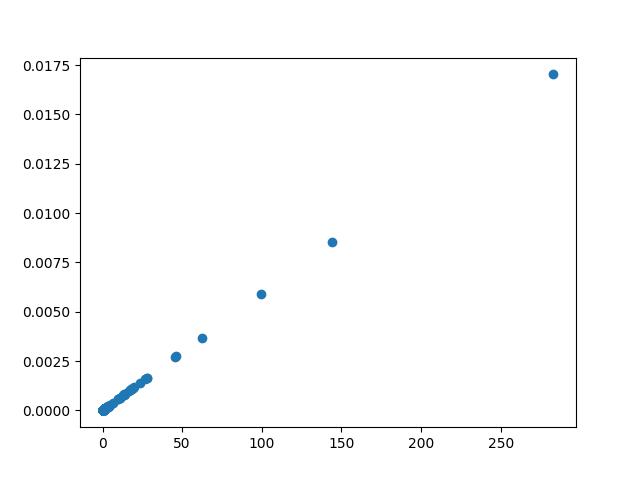

In [16]:
fig, axs = plt.subplots(1,1)
axs.scatter(dfs["tradesize_eth"], dfs["slippage"])
plt.show()

In [17]:
dfs[["tradesize_eth", "tradesize_usdc"]].head()

,tradesize_eth,tradesize_usdc
1,0.463638,583.354799
2,0.310963,388.915601
3,0.825983,1039.282967
4,0.043562,54.484329
5,0.25,312.679465


/var/folders/xv/9qwc_ryj6l98nrg9pnn_zp7h0000gn/T/ipykernel_9757/3677283774.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs["slippage_from_tradesize"] = abs((dfs["price_before"] - (dfs["tradesize_usdc"]/ dfs["tradesize_eth"])) / dfs["price_before"])


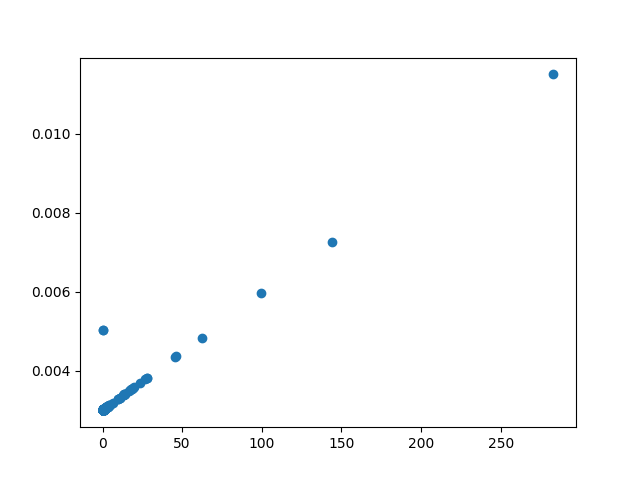

In [18]:
# slippage as: "trade_price = tradesize_usdc / tradesize_eth" -> slippage = (price_before - trade_price) / price_before

dfs["slippage_from_tradesize"] = abs((dfs["price_before"] - (dfs["tradesize_usdc"]/ dfs["tradesize_eth"])) / dfs["price_before"])
fig, axs = plt.subplots(1,1)
axs.scatter(dfs["tradesize_eth"], dfs["slippage_from_tradesize"])
plt.show()

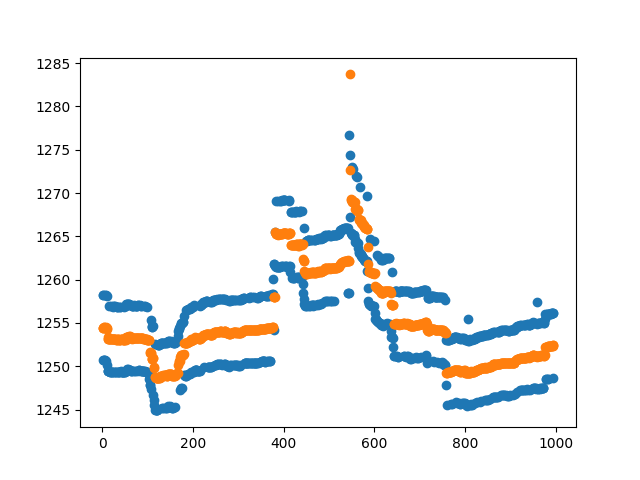

In [19]:
swap_prices = dfs["tradesize_usdc"] / dfs["tradesize_eth"]
reserve_prices = ((dfs["reserve0_before_calc"] / 10**6) / (dfs["reserve1_before_calc"]/ 10**18))
fig3, axs = plt.subplots(1,1)
axs.scatter(swap_prices.index, swap_prices)
axs.scatter(reserve_prices.index, reserve_prices)
plt.show()

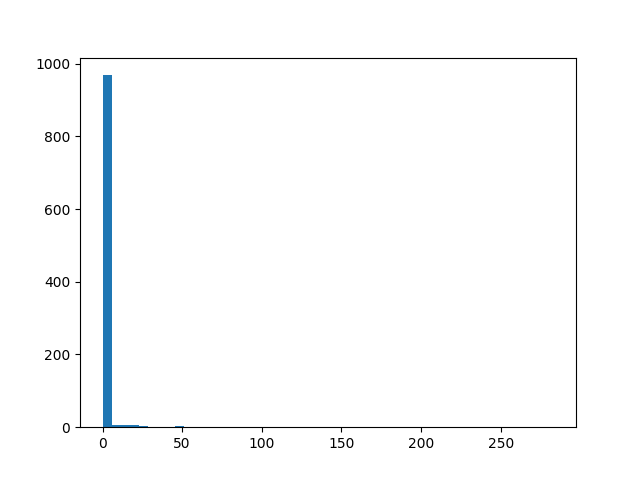

In [20]:
fig4, axs = plt.subplots(1,1)
axs.hist(dfs["tradesize_eth"], bins=50)
plt.show()